In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy.stats as stats
import scipy.special
#graphing
import matplotlib.pyplot as plt
#stats
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel

#import testing
import sys
sys.path.append("../")
import vuong_plots

In [2]:
beta0 = 1.
beta1 = .25

def gen_data(beta0=beta0,beta1=beta1):
    nobs = 1000
    #parameters
    sigma = 1
    
    epsilon = stats.norm.rvs(loc=0,scale=sigma,size=nobs)
    #censor data below x<0?
    x = stats.norm.rvs(loc=5,scale=5,size=nobs)
    y = beta0+ beta1*x + epsilon
    
    #censor
    y[y<=0] = 0
    return y,x,nobs


yn,xn,nobs = gen_data()
print(xn.shape)
print(sm.add_constant(xn).shape)
print(scipy.stats.mode(yn))

(1000,)
(1000, 2)
ModeResult(mode=array([0.]), count=array([87]))


In [3]:
class Tobit(GenericLikelihoodModel):
    
    def __init__(self, *args,ols=False, **kwargs):
        super(Tobit,self).__init__(*args,**kwargs)
        self.ols = ols

    def loglikeobs(self, params):
        y = self.endog
        x = self.exog
        m = 1*(self.endog == 0) #missingness
        
        beta = params
        
        mu_y = np.matmul(x,beta)
        
        pr_y = stats.norm.logpdf( y, loc = mu_y)
        
       
        #if complete case, assign pr missing to all observations...
        pr_m = stats.norm.logcdf( y, loc = mu_y)
        
        #we're done if ols
        if self.ols:
            return pr_y
        else:
            ll = (1-m)*pr_y + m*pr_m
            return ll
        
    def score(self, params):
        y = self.endog
        x = self.exog
        m = 1*(self.endog == 0) #missingness
        m_x = np.repeat(m,x.shape[1]).reshape(x.shape)
        
        if ols: #if OLS use all the data...
            m, m_x = np.ones(y.shape), np.ones(x.shape)
        
        
        b = params

        beta_jac = np.zeros(len(b))
        
        #for censored
        if not cc and not ols: 
            left_stats = (y - np.dot(x, b)) 
            l_pdf = scipy.stats.norm.logpdf(left_stats)
            l_cdf = scipy.stats.norm.logcdf(left_stats)
            left_frac = np.exp(l_pdf - l_cdf)
            beta_left = np.dot(left_frac*m, x*m_x)
            beta_jac -= beta_left
        
        #for non-censored
        mid_stats = (y - np.dot(x, b))
        beta_mid = np.dot(mid_stats*(1-m), x*(1-m_x) )
        beta_jac += beta_mid
        
        # by chain rule, since the expression above is dloglik/dlogsigma
        return beta_jac



model1 =  Tobit(yn,sm.add_constant(xn))
model1_fit = model1.fit(disp=False)
print(model1_fit.summary())

model2 =  Tobit(yn,sm.add_constant(xn),ols=True)
model2_fit = model2.fit(disp=False)
print(model2_fit.summary())

                                Tobit Results                                 
Dep. Variable:                      y   Log-Likelihood:                -1378.4
Model:                          Tobit   AIC:                             2761.
Method:            Maximum Likelihood   BIC:                             2771.
Date:                Fri, 19 Mar 2021                                         
Time:                        11:37:11                                         
No. Observations:                1000                                         
Df Residuals:                     998                                         
Df Model:                           1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9927      0.047     21.126      0.000       0.901       1.085
x1             0.2474      0.007     37.137      0.0

In [4]:
def setup_shi(yn,xn):
    model1 = Tobit(yn,sm.add_constant(xn))
    model1_fit = model1.fit(disp=False)
    ll1 = model1.loglikeobs(model1_fit.params)
    grad1 =  model1.score_obs(model1_fit.params)    
    hess1 = model1.hessian(model1_fit.params)
    k1 = len(model1_fit.params)
    
    #fit logistic values
    model2 = Tobit(yn,sm.add_constant(xn),ols=True)
    model2_fit = model2.fit(disp=False)
    ll2 = model2.loglikeobs(model2_fit.params)
    grad2 =  model2.score_obs(model2_fit.params)    
    hess2 = model2.hessian(model2_fit.params)
    k2 = len(model2_fit.params)
    
    return ll1,grad1,hess1,ll2,k1, grad2,hess2,k2

yn,xn,nobs = gen_data()
ll1,grad1,hess1,ll2,k1, grad2,hess2,k2 = setup_shi(yn,xn)

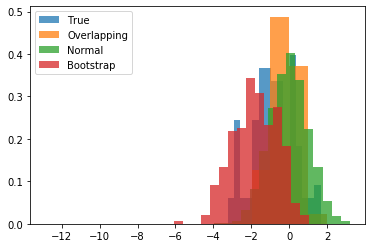

In [5]:
beta0 = 1.
beta1 = .25

def gen_data(beta0=beta0,beta1=beta1):
    nobs = 500
    #parameters
    sigma = 1
    
    epsilon = stats.norm.rvs(loc=0,scale=sigma,size=nobs)
    #censor data below x<0?
    x = stats.norm.rvs(loc=5,scale=5,size=nobs)
    y = beta0+ beta1*x + epsilon
    
    #censor
    y[y<=0] = 0
    return y,x,nobs


true_stats = vuong_plots.plot_true2(gen_data,setup_shi,trials=100)

yn,xn,nobs = gen_data()
anayltic_stats = vuong_plots.plot_analytic2(yn,xn,nobs,setup_shi)
bootstrap_stats = vuong_plots.plot_bootstrap2(yn,xn,nobs,setup_shi,trials=300)
plt.legend()
plt.savefig('../figs/tobit_plot25.png')
plt.show()

In [6]:
overlap,normal = anayltic_stats

#print moments/kstats
for i in range(1,5):
    print('%s --------'%i)
    for distr in [true_stats,overlap,normal,bootstrap_stats]:
        m, k = stats.moment(distr, i), stats.kstat(distr, i)
        print(m,k)
    print('---------')
ll1,grad1,hess1,ll2,k1, grad2,hess2,k2 = setup_shi(yn,xn)
thing1 = np.array(true_stats).mean() - np.array(bootstrap_stats).mean()
print(thing1)
thing2 = vuong_plots.compute_eigen2(ll1,grad1,hess1,ll2,k1, grad2,hess2,k2).sum()
print(thing2)
print(thing1/thing2)

1 --------
0.0 -0.8321272783608886
0.0 -0.24191086625696206
0.0 -0.01861788251506063
0.0 -1.7698255045663267
---------
2 --------
1.1998455048057677 1.2119651563694622
0.4492322342561263 0.44932209867586154
1.0030285687256604 1.0032292145685742
1.370824701729264 1.375409399728358
---------
3 --------
-0.09753259720522177 -0.10052834179058144
-0.4623650500789728 -0.46264259862674095
-0.021465236469412372 -0.02147812162413706
-0.3640340615063681 -0.36770291952563317
---------
4 --------
3.6333706482603896 -0.6439255530295145
5.722095461178764 5.124078805364642
2.9961197017287224 -0.020901436112370626
5.188870528703288 -0.42088915582516456
---------
0.9376982262054381
-0.29751339278573485
-3.151784924454664


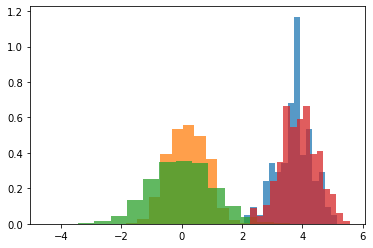

In [7]:
beta0 = 1.
beta1 = .5

def gen_data(beta0=beta0,beta1=beta1):
    nobs = 500
    #parameters
    sigma = 1
    
    epsilon = stats.norm.rvs(loc=0,scale=sigma,size=nobs)
    #censor data below x<0?
    x = stats.norm.rvs(loc=5,scale=5,size=nobs)
    y = beta0+ beta1*x + epsilon
    
    #censor
    y[y<=0] = 0
    return y,x,nobs

true_stats = vuong_plots.plot_true2(gen_data,setup_shi,trials=100)

yn,xn,nobs = gen_data()
anayltic_stats = vuong_plots.plot_analytic2(yn,xn,nobs,setup_shi)
bootstrap_stats = vuong_plots.plot_bootstrap2(yn,xn,nobs,setup_shi,trials=300)
plt.savefig('../figs/tobit_plot50.png')
plt.show()

In [8]:
overlap,normal = anayltic_stats

#print moments/kstats
for i in range(1,5):
    print('%s --------'%i)
    for distr in [true_stats,overlap,normal,bootstrap_stats]:
        m, k = stats.moment(distr, i), stats.kstat(distr, i)
        print(m,k)
    print('---------')
ll1,grad1,hess1,ll2,k1, grad2,hess2,k2 = setup_shi(yn,xn)
thing1 = np.array(true_stats).mean() - np.array(bootstrap_stats).mean()
print(thing1)
thing2 = vuong_plots.compute_eigen2(ll1,grad1,hess1,ll2,k1, grad2,hess2,k2).sum()
print(thing2)
print(thing1/thing2)

1 --------
0.0 3.7343428751120835
0.0 0.18855990338643855
0.0 0.003381467933911527
0.0 3.8987039757744264
---------
2 --------
0.3443598821684772 0.3478382648166382
0.3801244378048672 0.38020047790044736
1.0448327740508205 1.045041782407302
0.38015900446111117 0.38143043925863956
---------
3 --------
-0.05880451396277128 -0.060610713216608034
0.00750126151519276 0.007505764373355613
0.0075785498869808295 0.0075830991398167956
-0.008034624371415534 -0.008115600024987655
---------
4 --------
0.3559293543585758 0.007751589548380895
0.3943577314149777 -0.03900725648166609
3.185786768457903 -0.08805327125145496
0.40356651313041403 -0.027757424576724015
---------
-0.16436110066234288
0.6628119766071077
-0.24797545376849842


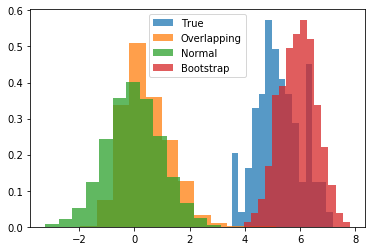

In [9]:
beta0 = 1.
beta1 = 1.

def gen_data(beta0=beta0,beta1=beta1):
    nobs = 500
    #parameters
    sigma = 1
    
    epsilon = stats.norm.rvs(loc=0,scale=sigma,size=nobs)
    #censor data below x<0?
    x = stats.norm.rvs(loc=5,scale=5,size=nobs)
    y = beta0+ beta1*x + epsilon
    
    #censor
    y[y<=0] = 0
    return y,x,nobs

true_stats = vuong_plots.plot_true2(gen_data,setup_shi,trials=100)

yn,xn,nobs = gen_data()
anayltic_stats = vuong_plots.plot_analytic2(yn,xn,nobs,setup_shi)
bootstrap_stats = vuong_plots.plot_bootstrap2(yn,xn,nobs,setup_shi,trials=300)
plt.legend()
plt.savefig('../figs/tobit_plot100.png')
plt.show()

In [10]:
overlap,normal = anayltic_stats

#print moments/kstats
for i in range(1,5):
    print('%s --------'%i)
    for distr in [true_stats,overlap,normal,bootstrap_stats]:
        m, k = stats.moment(distr, i), stats.kstat(distr, i)
        print(m,k)
    print('---------')
ll1,grad1,hess1,ll2,k1, grad2,hess2,k2 = setup_shi(yn,xn)
thing1 = np.array(true_stats).mean() - np.array(bootstrap_stats).mean()
print(thing1)
thing2 = vuong_plots.compute_eigen2(ll1,grad1,hess1,ll2,k1, grad2,hess2,k2).sum()
print(thing2)
print(thing1/thing2)

1 --------
0.0 5.245567158191901
0.0 0.43728475104506326
0.0 -0.026401323838837233
0.0 5.918876659464076
---------
2 --------
0.661215422456283 0.6678943661174612
0.7180402951082709 0.7181839318946499
0.9776159136692996 0.9778114759644927
0.44131149626119576 0.4427874544426672
---------
3 --------
0.0340421334524666 0.035087748353345154
0.49115284364145645 0.49144767292940034
0.013447632156031585 0.01345570450227653
-0.022352305631200074 -0.02257757970412021
---------
4 --------
1.0714762003837754 -0.2298499057966458
2.4474551749839635 0.9025911312013503
2.8610622561188594 -0.0049967095366324045
0.5345449728371241 -0.046925956581743235
---------
-0.6733095012721755
2.9182791226557026
-0.23072141936150645
